In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
image_path = "../output_videos/cropped_image.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

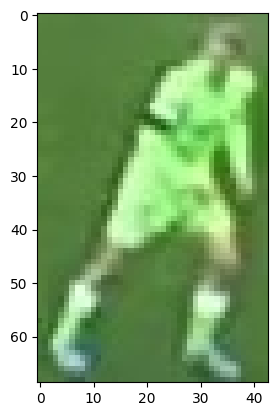

In [3]:
plt.imshow(image)
plt.show()

take the top half of the image

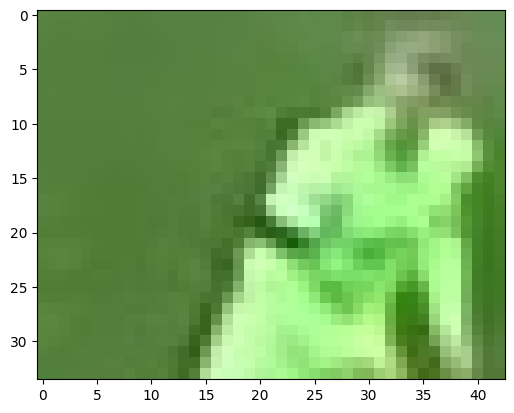

In [4]:
top_half_image=  image[0: int(image.shape[0]/2), :]
plt.imshow(top_half_image)
plt.show()

Cluster the image into two clusters

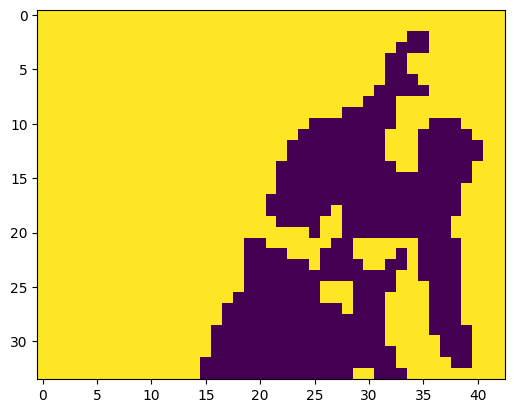

In [5]:
# Reshape the image into 2d array
image_2d = top_half_image.reshape(-1, 3)

# perform k-means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(image_2d)

# get the cluster labels
labels = kmeans.labels_

# reshape the labels into the orginal image shape
clustered_image = labels.reshape(top_half_image.shape[0], top_half_image.shape[1])

# Display the clustered image
plt.imshow(clustered_image)
plt.show()

In [6]:
corner_clusters = [clustered_image[0, 0], clustered_image[0, -1], clustered_image[-1, 0], clustered_image[-1, -1]]
non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
print(non_player_cluster)

1


In [7]:
player_cluster = 1-non_player_cluster
print(player_cluster)

0


In [ ]:
kmeans.cluster_centers_[player_cluster] 

array([168.68316832, 234.08168317, 143.2970297 ])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import cv2

class TeamAssigner:
    def __init__(self):
        self.team_colors = {}
        self.player_team_dict = {}
        self.kmeans = None

    def get_clustering_model(self, image):
        """Retourne un modèle K-means formé sur les couleurs de l'image"""
        image_2d = image.reshape(-1, 3)  # Reshape de l'image pour un clustering
        kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10)  # Utilisation de 2 clusters
        kmeans.fit(image_2d)
        return kmeans

    def get_player_color(self, frame, bbox):
        """Extrait la couleur dominante d'un joueur depuis l'image"""
        image = frame[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]  # Découpe la région du joueur
        top_half_image = image[0:int(image.shape[0] / 2), :]  # Prend la moitié supérieure de l'image

        # Utilisation de KMeans pour obtenir la couleur dominante
        kmeans = self.get_clustering_model(top_half_image)
        labels = kmeans.labels_  # Obtenons les labels pour chaque pixel

        # Recherche du cluster dominant
        corner_clusters = [labels[0, 0], labels[0, -1], labels[-1, 0], labels[-1, -1]]
        non_player_cluster = max(set(corner_clusters), key=corner_clusters.count)
        player_cluster = 1 - non_player_cluster

        # Retourne la couleur du cluster du joueur
        player_color = kmeans.cluster_centers_[player_cluster]
        return player_color

    def assign_team_color(self, frame, player_detections):
        """Assigner des couleurs d'équipe aux joueurs détectés"""
        player_colors = []

        for _, player_detection in player_detections.items():
            bbox = player_detection["bbox"]
            player_color = self.get_player_color(frame, bbox)
            player_colors.append(player_color)

        # Utilisation de KMeans pour regrouper les joueurs en 2 équipes selon leur couleur
        kmeans = KMeans(n_clusters=2, init="k-means++", n_init=10)
        kmeans.fit(player_colors)

        self.kmeans = kmeans

        # Assigner les couleurs des équipes
        self.team_colors[1] = kmeans.cluster_centers_[0]  # Équipe 1 : Première couleur
        self.team_colors[2] = kmeans.cluster_centers_[1]  # Équipe 2 : Deuxième couleur

    def get_player_team(self, frame, player_bbox, player_id):
        """Retourne l'équipe d'un joueur donné en fonction de son ID"""
        if player_id in self.player_team_dict:
            return self.player_team_dict[player_id]

        # Obtenir la couleur du joueur
        player_color = self.get_player_color(frame, player_bbox)

        # Prédire l'équipe du joueur avec le modèle K-means
        team_id = self.kmeans.predict(player_color.reshape(1, -1))[0]
        team_id += 1  # Assurer que l'équipe commence à 1

        # Exemple pour assigner un joueur spécifique à une équipe (par exemple, un joueur spécifique identifié par son ID)
        if player_id == 91:  # Cas d'un joueur particulier
            team_id = 1

        # Sauvegarde de l'assignation de l'équipe pour ce joueur
        self.player_team_dict[player_id] = team_id

        return team_id
